Install necessary packages. To run any Box2D game like car racing game, you may also need brew install following for MACOS.

brew install gcc@9
brew install swig

Also, some instructions and explanations about this project are given in readme.docx document, which you can have a look.

This work has GitHub links for further improvement or modification: https://github.com/kevinausrain/reinforment-learning-work

In [38]:
!pip install gymnasium==0.29.1
!pip install moviepy
!pip install matplotlib
!pip install ale-py
!pip install opencv-python
!pip install Box2D==2.3.2
!pip install Box2D-kengz==2.3.3
!pip install box2d-py==2.3.8
!pip install 'gymnasium[box2d]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 3.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 6.8 MB/s eta 0:00:0000:0100:01
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-macosx_11_0_arm64.whl size=373639 sha256=dbcba6dcc85741bcb1b1734443cf4ec61ebcc8e7c6830f17954df4f56b86846a
  Stored in directory: /Users/kevin/Library/Caches/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py
  Attempting uninstall: box2d-py
    Found existing installation: box2d-py 2.3.8
    Uninstalling box2d-py-2.3.8:
      Successfully uninstalled box2d-py-2.3.8


Utils functions

In [45]:
import cv2
import numpy as np


def box2d_preProcess(image):
    image = image[:84, 6:90]  
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0
    return image

def atari_preProcess(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # To grayscale
    image = image[20:210, 0:160]
    image = cv2.resize(image, (64, 80))  # Resize
    image = image.reshape(64, 80) / 255  # Normalize

    return image

def display_action_distribution(actions, action_num):
    display = '['
    for i in range(action_num):
        display = (display + str(i) + ':' + str(actions.count(i))
                   + '/' + str(len(actions)) + ' | ')
    display = display + ']'
    return display

CNN and DNN networks for agents to use

In [47]:
import random
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from gymnasium import spaces
import torch.nn.functional as F
from collections import deque
import moviepy.editor as mpy
import datetime
import util
from torch.distributions import Normal

def init_weight(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)

class CNNNetWork(nn.Module):
    def __init__(self, config):
        super(CNNNetWork, self).__init__()
        # create network layers
        layers = nn.ModuleList()
        conv1 = (nn.Conv2d(in_channels=config['conv1'][0],
                               out_channels=config['conv1'][1],
                               kernel_size=config['conv1'][2],
                               stride=config['conv1'][3])
                      )
        conv2 = (nn.Conv2d(in_channels=config['conv2'][0],
                               out_channels=config['conv2'][1],
                               kernel_size=config['conv2'][2],
                               stride=config['conv2'][3])
                      )

        layers.append(conv1)

        if not config['env_name'].startswith('CarRacing'):
            layers.append(nn.BatchNorm2d(config['conv1'][1]))

        layers.append(nn.ReLU())
        layers.append(conv2)

        if not config['env_name'].startswith('CarRacing'):
            layers.append(nn.BatchNorm2d(config['conv2'][1]))

        layers.append(nn.ReLU())

        try:
            conv3 = (nn.Conv2d(in_channels=config['conv3'][0],
                               out_channels=config['conv3'][1],
                               kernel_size=config['conv3'][2],
                               stride=config['conv3'][3])
                        )
            layers.append(conv3)
            layers.append(nn.BatchNorm2d(config['conv3'][1]))
            layers.append(nn.ReLU())
        except Exception as e:
            pass

        layers.append(nn.Flatten(start_dim=0))

        fc1 = nn.Linear(config['fc1'][0], config['fc1'][1])
        fc2 = nn.Linear(config['fc2'][0], config['fc2'][1])

        layers.append(fc1)

        if not config['env_name'].startswith('CarRacing'):
            layers.append(nn.LeakyReLU())

        layers.append(fc2)

        if config['type'] is 'policy':
            layers.append(nn.Softmax())

        self.net = nn.Sequential(*layers)

        if config['initial_weight_required']:
            self.apply(init_weight)

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=config['lr'])

    def forward(self, x):
        return self.net(x)

class CNNValueNetwork(CNNNetWork):
    def __init__(self, config):
        super(CNNValueNetwork, self).__init__(config)

    def update(self, inputs, targets, is_batch):
        self.optimizer.zero_grad()
        if is_batch:
            outputs = torch.stack([self.net(inp.unsqueeze(0)) for inp in inputs])
        else:
            outputs = self.net(inputs)
        loss = self.criterion(outputs, targets)
        before_params = [param.clone() for param in self.net.parameters()]
        loss.backward()
        self.optimizer.step()
        after_params = [param.clone() for param in self.net.parameters()]
        params_changed = [not torch.equal(before, after) for before, after in
                           zip(before_params, after_params)]
        #print("cnn value network parameters updated: ", any(params_changed))

        return loss


    def copy_from(self, qnetwork):
        self.load_state_dict(qnetwork.state_dict())


class CNNPolicyNetwork(CNNNetWork):
    def __init__(self, config):
        super(CNNPolicyNetwork, self).__init__(config)

    def update(self, states, actions, returns, is_batch):
        self.optimizer.zero_grad()
        #logits = self.net(states)
        if is_batch:
            action_probs = torch.stack([self.net(state.unsqueeze(0)) for state in states])
        else:
            action_probs = self.net(states)
        dist = torch.distributions.Categorical(logits=action_probs)
        #log_prob = dist.log_prob(normal_sample)
        #action = torch.tanh(normal_sample)
        #log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        loss = torch.mean(-dist.log_prob(actions) * returns)
        #before_params = [param.clone() for param in self.net.parameters()]
        loss.backward()
        self.optimizer.step()
        #after_params = [param.clone() for param in self.net.parameters()]
        #params_changed = [not torch.equal(before, after) for before, after in
        #                  zip(before_params, after_params)]

        #print("cnn policy network parameters updated: ", any(params_changed))

        return loss

class SACPolicyNetwork(nn.Module):
    def __init__(self, config):
        super(SACPolicyNetwork, self).__init__()
        # create network layers
        self.conv1 = nn.Conv2d(in_channels=config['conv1'][0],
                               out_channels=config['conv1'][1],
                               kernel_size=config['conv1'][2],
                               stride=config['conv1'][3])

        self.conv2 = nn.Conv2d(in_channels=config['conv2'][0],
                               out_channels=config['conv2'][1],
                               kernel_size=config['conv2'][2],
                               stride=config['conv2'][3]
                      )


        if not config['env_name'].startswith('CarRacing'):
            self.batchNorm1 = nn.BatchNorm2d(config['conv1'][1])


        if not config['env_name'].startswith('CarRacing'):
            self.batchNorm2 = nn.BatchNorm2d(config['conv2'][1])

        try:
            self.conv3 = nn.Conv2d(in_channels=config['conv3'][0],
                               out_channels=config['conv3'][1],
                               kernel_size=config['conv3'][2],
                               stride=config['conv3'][3])

            if not config['env_name'].startswith('CarRacing'):
                self.batchNorm3 = nn.BatchNorm2d(config['conv3'][1])
        except Exception as e:
            pass

        self.fc1 = nn.Linear(config['fc1'][0], config['fc1'][1])
        self.fc2 = nn.Linear(config['fc2'][0], config['fc2'][1])

        if config['initial_weight_required']:
            self.apply(init_weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        try:
            x = self.batchNorm1(x)
        except Exception as e:
            pass
        x = F.relu(self.conv2(x))
        try:
            x = self.batchNorm2(x)
        except Exception as e:
            pass
        try:
            x = F.relu(self.conv3(x))
            x = self.batchNorm3(x)
        except Exception as e:
            pass
        x = torch.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

class SACvalueNetwork(nn.Module):
    def __init__(self, config):
        super(SACvalueNetwork, self).__init__()
        # create network layers
        self.conv1 = nn.Conv2d(in_channels=config['conv1'][0],
                               out_channels=config['conv1'][1],
                               kernel_size=config['conv1'][2],
                               stride=config['conv1'][3])

        self.conv2 = nn.Conv2d(in_channels=config['conv2'][0],
                               out_channels=config['conv2'][1],
                               kernel_size=config['conv2'][2],
                               stride=config['conv2'][3]
                      )


        if not config['env_name'].startswith('CarRacing'):
            self.batchNorm1 = nn.BatchNorm2d(config['conv1'][1])


        if not config['env_name'].startswith('CarRacing'):
            self.batchNorm2 = nn.BatchNorm2d(config['conv2'][1])

        try:
            self.conv3 = nn.Conv2d(in_channels=config['conv3'][0],
                               out_channels=config['conv3'][1],
                               kernel_size=config['conv3'][2],
                               stride=config['conv3'][3])

            if not config['env_name'].startswith('CarRacing'):
                self.batchNorm3 = nn.BatchNorm2d(config['conv3'][1])
        except Exception as e:
            pass

        self.sac_value_fc1 = nn.Linear(config['fc1'][0], config['fc1'][1])
        self.sac_value_fc2 = nn.Linear(config['fc2'][0], config['fc2'][1])

        if config['initial_weight_required']:
            self.apply(init_weight)

    # x is state a is action
    def forward(self, x):
        x = F.relu(self.conv1(x))
        try:
            x = self.batchNorm1(x)
        except Exception as e:
            pass
        x = F.relu(self.conv2(x))
        try:
            x = self.batchNorm2(x)
        except Exception as e:
            pass
        try:
            x = F.relu(self.conv3(x))
            x = self.batchNorm3(x)
        except Exception as e:
            pass
        x = torch.flatten(x)
        x = F.relu(self.sac_value_fc1(x))
        x = self.sac_value_fc2(x)
        return x


class DNNNetwork(nn.Module):
    def __init__(self, config):
        super(DNNNetwork, self).__init__()
        # create network layers
        layers = nn.ModuleList()

        fc1 = nn.Linear(config['dnn_fc1'][0], config['dnn_fc1'][1])
        fc2 = nn.Linear(config['dnn_fc2'][0], config['dnn_fc2'][1])
        fc3 = nn.Linear(config['dnn_fc3'][0], config['dnn_fc3'][1])

        layers.append(fc1)
        layers.append(nn.ReLU())
        layers.append(fc2)
        layers.append(nn.ReLU())
        layers.append(fc3)

        if config['type'] is 'policy':
            layers.append(nn.Softmax())

        self.net = nn.Sequential(*layers)

        if config['initial_weight_required']:
            self.apply(init_weight)

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=config['lr'])

    def forward(self, x):
        return self.net(x)

class DNNValueNetwork(DNNNetwork):
    def __init__(self, config):
        super(DNNValueNetwork, self).__init__(config)

    def update(self, inputs, targets):
        self.optimizer.zero_grad()
        outputs = self.net(inputs)
        loss = self.criterion(outputs, targets)
        before_params = [param.clone() for param in self.net.parameters()]
        loss.backward()
        self.optimizer.step()
        after_params = [param.clone() for param in self.net.parameters()]
        params_changed = [not torch.equal(before, after) for before, after in
                           zip(before_params, after_params)]
        #print("cnn value network parameters updated: ", any(params_changed))

        return loss


    def copy_from(self, qnetwork):
        self.load_state_dict(qnetwork.state_dict())


class DNNPolicyNetwork(DNNNetwork):
    def __init__(self, config):
        super(DNNPolicyNetwork, self).__init__(config)

    def update(self, states, actions, returns):
        self.optimizer.zero_grad()
        #logits = self.net(states)
        action_probs = self.net(states)
        dist = torch.distributions.Categorical(logits=action_probs)
        loss = torch.mean(-dist.log_prob(actions) * returns)
        #before_params = [param.clone() for param in self.net.parameters()]
        loss.backward()
        self.optimizer.step()
        #after_params = [param.clone() for param in self.net.parameters()]
        #params_changed = [not torch.equal(before, after) for before, after in
        #                  zip(before_params, after_params)]

        #print("cnn policy network parameters updated: ", any(params_changed))

        return loss

class SACDNNPolicyNetwork(nn.Module):
    def __init__(self, config):
        super(SACDNNPolicyNetwork, self).__init__()
        layers = nn.ModuleList()
        layers.append(nn.Linear(config['dnn_fc1'][0], config['dnn_fc1'][1]))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(config['dnn_fc2'][0], config['dnn_fc2'][1]))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(config['dnn_fc3'][0], config['dnn_fc3'][1]))
        layers.append(nn.Softmax())

        self.net = nn.Sequential(*layers)

        if config['initial_weight_required']:
            self.apply(init_weight)

    def forward(self, x):
        return self.net(x)

class SACDNNValueNetwork(nn.Module):
    def __init__(self, config):
        super(SACDNNValueNetwork, self).__init__()
        layers = nn.ModuleList()
        layers.append(nn.Linear(config['dnn_fc1'][0], config['dnn_fc1'][1]))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(config['dnn_fc2'][0], config['dnn_fc2'][1]))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(config['dnn_fc3'][0], config['dnn_fc3'][1]))

        self.net = nn.Sequential(*layers)

        if config['initial_weight_required']:
            self.apply(init_weight)

    def forward(self, x):
        return self.net(x)


Agents of DQN, REINFORCE and Actor-Critic and SAC mainly based on implementation from lecture Practicals, with modification

In [65]:
import random
import time

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from gymnasium import spaces
import torch.nn.functional as F
from collections import deque
import moviepy.editor as mpy
import datetime
from Network import *
import util

save_record_path = '/Users/kevin/PycharmProjects/reinforment-learning-work/work/record/'
save_model_path = '/Users/kevin/PycharmProjects/reinforment-learning-work/work/saved_model/'


class DQN():
    def __init__(self, env_name, env, model_name, config):
        self.env = env
        self.env_name = env_name
        self.network_type = config['network_type']

        if self.network_type is 'cnn':
            self.qnet = CNNValueNetwork(config)
            self.target_qnet = CNNValueNetwork(config)
        else:
            self.qnet = DNNValueNetwork(config)
            self.target_qnet = DNNValueNetwork(config)

        if model_name is not None:
            self.load(model_name)
            print('load success')
        else:
            self.target_qnet.copy_from(self.qnet)

        self.max_step = config['max_step']
        self.replay_buffer = deque(maxlen=config['replay_buffer'])
        self.buffer_size = config['replay_buffer']
        self.minibatch_size = config['minibatch_size']
        self.batch_size = config['batch_size']
        self.target_update = config['target_update']
        self.target_update_idx = 0
        self.rng = np.random.default_rng()
        self.warm_up_steps = config['warm_up_steps']
        self.learning_rate = config['lr']
        self.initial_weight_required = config['initial_weight_required']

        self.is_action_discrete = config['is_action_discrete']
        self.is_observation_space_image = config['is_observation_space_image']
        self.discount = config['discount']
        self.epsilon = config['greedy']
        self.epsilon_min = config['greedy_min']
        self.decay_speed = config['decay_speed']

        self.stack_frame_num = config['stack_frame_num']
        self.skip_frame_num = config['skip_frame_num']
        self.use_skip_frame = config['use_skip_frame']
        self.frames = deque(maxlen=self.skip_frame_num)
        self.preferable_action_probs = config['preferable_action_probs']
        self.actions = config['actions']

    def behaviour(self, state, steps, stochastic=True):
        if self.network_type is 'cnn':
            state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        else:
            state = torch.flatten(torch.tensor(state, dtype=torch.float))

        if stochastic and (random.random() <= self.epsilon or steps <= self.warm_up_steps):
            return np.random.choice(self.actions, size = 1, p=self.preferable_action_probs)[0]
        else:
            state = torch.tensor(state, dtype=torch.float)
            q = self.qnet.forward(state).detach()
            j = self.rng.permutation(self.env.action_space.n)
            return j[q[j].argmax().item()]

    def policy(self, state):
        if not torch.is_tensor(state):
            if self.network_type is 'cnn':
                state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            else:
                state = torch.flatten(torch.tensor(state, dtype=torch.float))

        return self.qnet(state).detach().argmax().item()

    def update(self):
        loss = 0
        if len(self.replay_buffer) >= self.minibatch_size:
            batch = self.rng.choice(len(self.replay_buffer), size=self.batch_size, replace=False)
            if self.network_type is 'cnn':
                if self.env_name.startswith('CarRacing'):
                    inputs = torch.zeros((self.batch_size, self.stack_frame_num, 84, 84))
                else:
                    inputs = torch.zeros((self.batch_size, self.stack_frame_num, 64, 80))
            else:
                if self.env_name.startswith('CarRacing'):
                    inputs = torch.zeros((self.batch_size, self.stack_frame_num * 84 * 84))
                else:
                    inputs = torch.zeros((self.batch_size, self.stack_frame_num * 64 * 80))

            targets = torch.zeros((self.batch_size, self.env.action_space.n))
            for n, index in enumerate(batch):
                state, action, reward, next_state, terminated = self.replay_buffer[index]
                state = torch.tensor(state, dtype=torch.float)
                if self.network_type is 'cnn':
                    inputs[n, :] = state
                else:
                    inputs[n, :] = torch.flatten(state)
                if self.network_type is 'cnn':
                    targets[n, :] = self.target_qnet(state.unsqueeze(0)).detach()
                else:
                    targets[n, :] = self.target_qnet(torch.flatten(state)).detach()
                if terminated:
                    targets[n, action] = reward
                else:
                    if self.network_type is 'cnn':
                        next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0)
                    else:
                        next_state = torch.flatten(torch.tensor(next_state, dtype=torch.float))
                    targets[n, action] = reward + self.discount * self.target_qnet(next_state).detach().max()

            if self.network_type is 'cnn':
                loss = self.qnet.update(inputs, targets, True)
            else:
                loss = self.qnet.update(inputs, targets)

        self.target_update_idx += 1
        if self.target_update_idx % self.target_update == 0:
            self.target_qnet.copy_from(self.qnet)

        return loss

    def train(self, max_episodes, stop_criterion, criterion_episodes):
        now = time.time()
        txt = open(save_record_path + str(datetime.datetime.now()) + '_' + self.env_name +
                   '_greedy_' + str(self.epsilon).replace(".", "") +
                   '_greedy_min_' + str(self.epsilon_min).replace(".", "") +
                   '_decay_speed_' + str(self.decay_speed).replace(".", "") +
                   '_buffer_size_' + str(self.buffer_size) +
                   '_target_update_freq_' + str(self.target_update) +
                   '_use_skip_frame_' + str(self.use_skip_frame) +
                   '_lr_' + str(self.learning_rate) +
                   '_init_w_' + str(self.initial_weight_required) + '_dqn.txt', 'a')
        rewards = []
        num_steps = 0
        for episode in range(max_episodes):
            state, _ = self.env.reset()
            if self.env_name is 'CarRacing':
                state = util.box2d_preProcess(state)
            else:
                state = util.atari_preProcess(state)

            for i in range(self.stack_frame_num):
                self.frames.append(state)
            state = np.stack(self.frames)

            terminated = False
            truncated = False
            rewards.append(0)
            loss = 0
            actions = []
            skipped = 0
            last_action = None
            while not (terminated or truncated):
                if self.use_skip_frame:
                    if skipped == 0:
                        action = self.behaviour(state, num_steps, True)
                        last_action = action
                    else:
                        action = last_action
                else:
                    action = self.behaviour(state, num_steps, True)

                skipped = (skipped + 1) % self.skip_frame_num
                next_state, reward, terminated, truncated, _ = self.env.step(action)

                if self.env_name is 'CarRacing':
                    next_state = util.box2d_preProcess(next_state)
                else:
                    next_state = util.atari_preProcess(next_state)

                self.frames.append(next_state)
                next_state = np.stack(self.frames)

                self.replay_buffer.append((state, action, reward, next_state, terminated))
                actions.append(action)

                loss += self.update()
                self.epsilon = max(self.epsilon - self.decay_speed, self.epsilon_min)

                state = next_state
                rewards[-1] += reward
                num_steps += 1

                if num_steps >= self.max_step:
                    break

            txt.write("Episode {} done, steps = {}, actions = {}, loss = {}, rewards = {}, consume time = {}s\n".format(
                episode + 1, num_steps, util.display_action_distribution(actions, len(self.actions)),
                loss, rewards[episode], time.time() - now))
            print(f'Episode {episode + 1} done, steps = {num_steps}, actions = {util.display_action_distribution(actions, len(self.actions))}, '
                  f'loss = {loss}, epsilon = {self.epsilon}, rewards = {rewards[episode]}')

            if episode >= criterion_episodes - 1 and episode % 50 == 0:
                if stop_criterion(rewards[-criterion_episodes:]):
                    self.save(save_model_path + str(datetime.datetime.now()) + '_' + self.env_name + '_greedy_' + str(self.epsilon).replace(".", "") +'_dqn')
                    print(f'\nStopping criterion satisfied after {episode} episodes')
                    break
                else:
                    self.save(save_model_path + str(datetime.datetime.now()) + '_' + self.env_name + '_greedy_' + str(self.epsilon).replace(".", "") +'_dqn_fail')

        plt.figure(dpi=100)
        plt.plot(range(1, len(rewards) + 1), rewards, label=f'Rewards')

        plt.xlabel('Episodes')
        plt.ylabel('Rewards per episode')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

    def save(self, path):
        torch.save(self.qnet.state_dict(), path)

    def load(self, path):
        self.qnet.load_state_dict(torch.load(path))
        self.target_qnet.copy_from(self.qnet)


class REINFORCE():
    def __init__(self, env_name, env, model_name, config):
        self.env = env
        self.env_name = env_name
        self.preferable_action_probs = config['preferable_action_probs']
        self.is_action_discrete = config['is_action_discrete']
        self.is_observation_space_image = config['is_observation_space_image']
        self.discount = config['discount']
        self.epsilon = config['greedy']
        self.epsilon_min = config['greedy_min']
        self.decay_speed = config['decay_speed']
        self.warm_up_steps = config['warm_up_steps']
        self.network_type = config['network_type']
        self.learning_rate = config['lr']
        self.initial_weight_required = config['initial_weight_required']

        if self.network_type is 'cnn':
            self.policy_net = CNNPolicyNetwork(config)
        else:
            self.policy_net = DNNPolicyNetwork(config)

        if model_name is not None:
            self.load(model_name)

        self.stack_frame_num = config['stack_frame_num']
        self.frames = deque(maxlen=self.stack_frame_num)
        self.skip_frame_num = config['skip_frame_num']
        self.use_skip_frame = config['use_skip_frame']

        self.preferable_action_probs = config['preferable_action_probs']
        self.actions = config['actions']


    def policy(self, state, stochastic=True):
        if not torch.is_tensor(state):
            if self.network_type is 'cnn':
                state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            else:
                state = torch.flatten(torch.tensor(state, dtype=torch.float))

        action_probs = self.policy_net(state).detach()
        dist = torch.distributions.Categorical(logits=action_probs)

        if stochastic:
            return dist.sample().item()
        else:
            return dist.probs.argmax().item()

    def update(self, trajectory):
        states, actions, rewards = list(zip(*trajectory))
        returns = torch.zeros((len(trajectory),))
        returns[-1] = rewards[-1]

        for t in reversed(range(len(trajectory) - 1)):
            returns[t] = rewards[t] + self.discount * returns[t + 1]

        if self.network_type is 'cnn':
            states = torch.tensor(states, dtype=torch.float)
        else:
            states = torch.stack([torch.flatten(torch.tensor(state, dtype=torch.float))
                                  for state in states])

        actions = torch.tensor(actions)

        if self.network_type is 'cnn':
            return self.policy_net.update(states, actions, returns, True)
        else:
            return self.policy_net.update(states, actions, returns)

    def train(self, max_episodes, stop_criterion, criterion_episodes):
        txt = open(save_record_path + str(datetime.datetime.now()) + '_' + self.env_name +
                   '_lr_' + str(self.learning_rate) +
                   '_use_skip_frame_' + str(self.use_skip_frame) +
                   '_init_w_' + str(self.initial_weight_required) + '_rein.txt', 'a')
        now = time.time()
        num_steps = 0
        episode_rewards = []
        for episode in range(max_episodes):
            state, _ = self.env.reset()
            if self.env_name is 'CarRacing':
                state = util.box2d_preProcess(state)
            else:
                state = util.atari_preProcess(state)

            for i in range(self.stack_frame_num):
                self.frames.append(state)
            state = np.stack(self.frames)

            terminated = False
            truncated = False
            episode_rewards.append(0)
            trajectory = []
            loss = 0
            actions = []
            skipped = 0
            last_action = None

            while not (terminated or truncated):
                if self.use_skip_frame:
                    if skipped == 0:
                        action = self.policy(state)
                        last_action = action
                    else:
                        action = last_action
                else:
                    action = self.policy(state)

                next_state, reward, terminated, truncated, _ = self.env.step(action)
                episode_rewards[-1] += reward

                if not self.env_name.startswith('CarRacing'):
                    trajectory.append((state, action, reward))
                    actions.append(action)
                else:
                    trajectory.append((state, action, reward))
                    actions.append(action)

                if self.env_name is 'CarRacing':
                    next_state = util.box2d_preProcess(next_state)
                else:
                    next_state = util.atari_preProcess(next_state)

                self.frames.append(next_state)
                next_state = np.stack(self.frames)

                state = next_state
                num_steps += 1

                if num_steps % 1000 == 0:
                    self.epsilon = max(self.epsilon - self.decay_speed, self.epsilon_min)

            if len(trajectory) > 0:
                loss = self.update(trajectory)

            txt.write("Episode {} done, steps = {}, actions = {}, loss = {}, rewards = {}, consume time = {}s\n".format(
                episode + 1, num_steps, util.display_action_distribution(actions, len(self.actions)),
                loss, episode_rewards[episode], time.time() - now))
            print(f'Episode {episode + 1} done, steps = {num_steps}, actions = {util.display_action_distribution(actions, len(self.actions))}, '
                  f'loss = {loss}, epsilon = {self.epsilon}, '
                  f'rewards = {episode_rewards[episode]}')

            if episode >= criterion_episodes - 1 and episode % 100 == 0:
                if stop_criterion(episode_rewards[-criterion_episodes:]):
                    self.save(save_model_path + str(datetime.datetime.now()) + '_' + self.env_name + '_lr_' + str(self.learning_rate).replace(".", "") +'_rein')
                    print(f'\nStopping criterion satisfied after {episode} episodes')
                    break
                else:
                    self.save(save_model_path + str(datetime.datetime.now()) + '_' + self.env_name + '_lr_' + str(self.learning_rate).replace(".", "") +'_rein_fail')

        # plot rewards received during training
        plt.figure(dpi=100)
        plt.plot(range(1, len(episode_rewards) + 1), episode_rewards, label=f'Rewards')

        plt.xlabel('Episodes')
        plt.ylabel('Rewards per episode')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

    def save(self, path):
        torch.save(self.policy_net.state_dict(), path)

    def load(self, path):
        self.policy_net.load_state_dict(torch.load(path))

class ActorCritic():
    def __init__(self, env_name, env, model_name, policy_config, value_config):
        self.env = env
        self.env_name = env_name
        self.network_type = policy_config['network_type']

        if self.network_type is 'cnn':
            self.policy_net = CNNPolicyNetwork(policy_config)
            self.value_net = CNNValueNetwork(value_config)
        else:
            self.policy_net = DNNPolicyNetwork(policy_config)
            self.value_net = DNNValueNetwork(value_config)

        if model_name is not None:
            self.load(model_name)
            print('load success')

        self.is_action_discrete = policy_config['is_action_discrete']
        self.is_observation_space_image = policy_config['is_observation_space_image']
        self.discount = policy_config['discount']
        self.epsilon = policy_config['greedy']
        self.epsilon_min = policy_config['greedy_min']
        self.decay_speed = policy_config['decay_speed']
        self.warm_up_steps = policy_config['warm_up_steps']
        self.learning_rate = policy_config['lr']
        self.initial_weight_required = policy_config['initial_weight_required']

        self.stack_frame_num = policy_config['stack_frame_num']
        self.frames = deque(maxlen=self.stack_frame_num)
        self.skip_frame_num = policy_config['skip_frame_num']
        self.use_skip_frame = policy_config['use_skip_frame']

        self.preferable_action_probs = policy_config['preferable_action_probs']
        self.actions = policy_config['actions']

    def policy(self, state, stochastic=True):
        if not torch.is_tensor(state):
            if self.network_type is 'cnn':
                state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            else:
                state = torch.flatten(torch.tensor(state, dtype=torch.float))

        action_probs = self.policy_net(state).detach()
        dist = torch.distributions.Categorical(logits=action_probs)

        if stochastic:
            return dist.sample().item()
        else:
            return dist.probs.argmax().item()

    def update(self, state, action, reward, next_state, terminated):
        if not torch.is_tensor(state):
            if self.network_type is 'cnn':
                state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            else:
                state = torch.flatten(torch.tensor(state, dtype=torch.float))

        if not torch.is_tensor(next_state):
            if self.network_type is 'cnn':
                next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0)
            else:
                next_state = torch.flatten(torch.tensor(next_state, dtype=torch.float))

        if terminated:
            target = reward
        else:
            target = reward + self.discount * self.value_net(next_state).detach()

        target = torch.tensor([target], dtype=torch.float)
        delta = target - self.value_net(state).detach()

        action = torch.tensor(action)

        if self.network_type is 'cnn':
            policy_loss = self.policy_net.update(state, action, delta, False)
            value_loss = self.value_net.update(state, target, False)
        else:
            policy_loss = self.policy_net.update(state, action, delta)
            value_loss = self.value_net.update(state, target)

        return policy_loss, value_loss


    def train(self, max_episodes, stop_criterion, criterion_episodes):
        txt = open(save_record_path + str(datetime.datetime.now()) + '_' + self.env_name +
                   '_lr_' + str(self.learning_rate) +
                   '_use_skip_frame_' + str(self.use_skip_frame) +
                   '_init_w_' + str(self.initial_weight_required) + '_ac.txt', 'a')
        now = time.time()
        num_steps = 0
        episode_rewards = []

        for episode in range(max_episodes):
            state, _ = self.env.reset()

            if self.env_name is 'CarRacing':
                state = util.box2d_preProcess(state)
            else:
                state = util.atari_preProcess(state)

            for i in range(self.stack_frame_num):
                self.frames.append(state)
            state = np.stack(self.frames)

            terminated = False
            truncated = False
            episode_rewards.append(0)

            policy_loss = 0
            value_loss = 0
            actions = []
            skipped = 0
            last_action = None

            while not (terminated or truncated):
                if self.use_skip_frame:
                    if skipped == 0:
                        action = self.policy(state)
                        last_action = action
                    else:
                        action = last_action
                else:
                    action = self.policy(state)

                next_state, reward, terminated, truncated, _ = self.env.step(action)
                episode_rewards[-1] += reward

                if self.env_name is 'CarRacing':
                    next_state = util.box2d_preProcess(next_state)
                else:
                    next_state = util.atari_preProcess(next_state)

                self.frames.append(next_state)
                next_state = np.stack(self.frames)

                p_loss, v_loss = self.update(state, action, reward, next_state, terminated)

                if p_loss != 0.0:
                    policy_loss = p_loss

                if v_loss != 0.0:
                    value_loss = v_loss

                actions.append(action)

                num_steps += 1
                self.epsilon = max(self.epsilon - self.decay_speed, self.epsilon_min)

            txt.write("Episode {} done, steps = {}, actions = {}, p_loss = {}, v_loss = {}, rewards = {}, consume time = {}s\n".format(
                episode + 1, num_steps, util.display_action_distribution(actions, len(self.actions)), policy_loss, value_loss, episode_rewards[episode], time.time() - now))
            print(f'Episode {episode + 1} done, steps = {num_steps}, '
                  f'actions = {util.display_action_distribution(actions, len(self.actions))}, '
                  f'p_loss = {policy_loss}, v_loss = {value_loss}, '
                  f'epsilon = {self.epsilon}, rewards = {episode_rewards[episode]}')

            if episode >= criterion_episodes - 1 and episode % 100 == 0:
                if stop_criterion(episode_rewards[-criterion_episodes:]):
                    self.save(save_model_path + str(datetime.datetime.now()) + '_' + self.env_name + '_lr_' + str(self.learning_rate).replace(".",
                                                                                                                    "") + '_ac')
                    print(f'\nStopping criterion satisfied after {episode} episodes')
                    break
                else:
                    self.save(save_model_path + str(datetime.datetime.now()) + '_' + self.env_name + '_lr_' + str(self.learning_rate).replace(".",
                                                                                                                "") + '_ac_fail')

        plt.figure(dpi=100)
        plt.plot(range(1, len(episode_rewards) + 1), episode_rewards, label=f'Rewards')

        plt.xlabel('Episodes')
        plt.ylabel('Rewards per episode')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

    def save(self, path):
        torch.save({'policy': self.policy_net.state_dict(),
                    'value': self.value_net.state_dict()}, path)

    def load(self, path):
        networks = torch.load(path)
        self.policy_net.load_state_dict(networks['policy'])
        self.value_net.load_state_dict(networks['value'])

class SAC():
    def __init__(self, env_name, env, model_name, policy_config, value_config):
        self.env = env
        self.env_name = env_name
        self.network_type = policy_config['network_type']

        if self.network_type is 'cnn':
            self.actor_net = SACPolicyNetwork(policy_config)
            self.critic_net_1 = SACvalueNetwork(value_config)
            self.critic_net_2 = SACvalueNetwork(value_config)
            self.target_critic_net_1 = SACvalueNetwork(value_config)
            self.target_critic_net_2 = SACvalueNetwork(value_config)
        else:
            self.actor_net = SACDNNPolicyNetwork(policy_config)
            self.critic_net_1 = SACDNNValueNetwork(value_config)
            self.critic_net_2 = SACDNNValueNetwork(value_config)
            self.target_critic_net_1 = SACDNNValueNetwork(value_config)
            self.target_critic_net_2 = SACDNNValueNetwork(value_config)

        self.actor_net_optimizer = torch.optim.Adam(self.actor_net.parameters(), lr=policy_config['lr'])
        self.critic_net_1_optimizer = torch.optim.Adam(self.critic_net_1.parameters(), lr=value_config['lr'])
        self.critic_net_2_optimizer = torch.optim.Adam(self.critic_net_2.parameters(), lr=value_config['lr'])

        if model_name is not None:
            self.load(model_name)
            print('load success')

        self.is_action_discrete = policy_config['is_action_discrete']
        self.is_observation_space_image = policy_config['is_observation_space_image']
        self.discount = policy_config['discount']
        self.tau = policy_config['tau']
        self.epsilon = policy_config['greedy']
        self.epsilon_min = policy_config['greedy_min']
        self.decay_speed = policy_config['decay_speed']
        self.warm_up_steps = policy_config['warm_up_steps']
        self.learning_rate = policy_config['lr']
        self.initial_weight_required = policy_config['initial_weight_required']

        self.replay_buffer = deque(maxlen=policy_config['replay_buffer'])
        self.buffer_size = policy_config['replay_buffer']
        self.minibatch_size = policy_config['minibatch_size']
        self.batch_size = policy_config['batch_size']

        self.stack_frame_num = policy_config['stack_frame_num']
        self.frames = deque(maxlen=self.stack_frame_num)
        self.skip_frame_num = policy_config['skip_frame_num']
        self.use_skip_frame = policy_config['use_skip_frame']

        self.preferable_action_probs = policy_config['preferable_action_probs']
        self.actions = policy_config['actions']
        self.target_entropy = policy_config['target_entropy']

        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=policy_config['alpha_lr'])

    def sac_policy(self, state):
        if not torch.is_tensor(state):
            if self.network_type is 'cnn':
                state = torch.tensor(state, dtype=torch.float)
            else:
                state = torch.flatten(torch.tensor(state, dtype=torch.float))
        probs = self.actor_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def calculate_target_value(self, rewards, next_states, terminated):
        if self.network_type is 'cnn':
            next_probs = torch.stack([self.actor_net(next_state) for next_state in next_states])
        else:
            next_probs = self.actor_net(next_states)

        next_log_probs = torch.log(next_probs + 1e-8)
        entropy = -torch.sum(next_probs * next_log_probs, dim=1, keepdim=True)
        q1_value = torch.stack([self.critic_net_1(next_state) for next_state in next_states])
        q2_value = torch.stack([self.critic_net_2(next_state) for next_state in next_states])
        min_qvalue = torch.sum(next_probs * torch.min(q1_value, q2_value), dim=1, keepdim=True)
        next_value = min_qvalue + self.log_alpha.exp() * entropy
        td_target = rewards + self.discount * next_value * (1 - terminated)

        return td_target


    def update(self, transition_dict):
        if self.network_type is 'cnn':
            states = torch.tensor(transition_dict['states'], dtype=torch.float)
            actions = torch.tensor(transition_dict['actions']).view(-1, 1)
            rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1)
            next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float)
            dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1)
        else:
            states = torch.stack([torch.flatten(torch.tensor(state, dtype=torch.float)) for state in transition_dict['states']])
            actions = torch.tensor(transition_dict['actions']).view(-1, 1)
            rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1)
            next_states = torch.stack([torch.flatten(torch.tensor(state,  dtype=torch.float)) for state in transition_dict['next_states']])
            dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1)

        td_target = self.calculate_target_value(rewards, next_states, dones)

        if self.network_type is 'cnn':
            critic_1_q_values = torch.stack([self.critic_net_1(state) for state in states])
        else:
            critic_1_q_values = self.critic_net_1(states)

        critic_1_loss = torch.mean(F.mse_loss(critic_1_q_values, td_target.detach()))

        if self.network_type is 'cnn':
            critic_2_q_values = torch.stack([self.critic_net_2(state) for state in states])
        else:
            critic_2_q_values = self.critic_net_2(states)

        critic_2_loss = torch.mean(F.mse_loss(critic_2_q_values, td_target.detach()))

        self.critic_net_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_net_1_optimizer.step()
        self.critic_net_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_net_2_optimizer.step()

        if self.network_type is 'cnn':
            probs = torch.stack([self.actor_net(state) for state in states])
        else:
            probs = self.actor_net(states)

        log_probs = torch.log(probs + 1e-8)

        entropy = -torch.sum(probs * log_probs, dim=1, keepdim=True)

        if self.network_type is 'cnn':
            q1_value = torch.stack([self.critic_net_1(state) for state in states])
            q2_value = torch.stack([self.critic_net_2(state) for state in states])
        else:
            q1_value = self.critic_net_1(states)
            q2_value = self.critic_net_2(states)

        min_qvalue = torch.sum(probs * torch.min(q1_value, q2_value), dim=1, keepdim=True)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - min_qvalue)
        self.actor_net_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_net_optimizer.step()

        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_net_1, self.target_critic_net_1)
        self.soft_update(self.critic_net_2, self.target_critic_net_2)

        return actor_loss, critic_1_loss + critic_2_loss

    def train(self, max_episodes, stop_criterion, criterion_episodes):
        txt = open(save_record_path + str(datetime.datetime.now()) + '_' + self.env_name +
                   '_lr_' + str(self.learning_rate) +
                   '_use_skip_frame_' + str(self.use_skip_frame) +
                   '_tau_' + str(self.tau) +
                   '_init_w_' + str(self.initial_weight_required) + '_sac.txt', 'a')
        now = time.time()
        num_steps = 0
        episode_rewards = []

        for episode in range(max_episodes):
            state, _ = self.env.reset()

            if self.env_name is 'CarRacing':
                state = util.box2d_preProcess(state)
            else:
                state = util.atari_preProcess(state)

            for i in range(self.stack_frame_num):
                self.frames.append(state)
            state = np.stack(self.frames)

            terminated = False
            truncated = False
            episode_rewards.append(0)

            policy_loss = 0
            value_loss = 0
            action_list = []
            skipped = 0
            last_action = None

            while not (terminated or truncated):
                if self.use_skip_frame:
                    if skipped == 0:
                        action = self.sac_policy(state)
                        last_action = action
                    else:
                        action = last_action
                else:
                    action = self.sac_policy(state)

                next_state, reward, terminated, truncated, _ = self.env.step(action)
                episode_rewards[-1] += reward

                if self.env_name is 'CarRacing':
                    next_state = util.box2d_preProcess(next_state)
                else:
                    next_state = util.atari_preProcess(next_state)

                self.frames.append(next_state)
                next_state = np.stack(self.frames)

                self.replay_buffer.append((state, action, reward, next_state, terminated))

                if len(self.replay_buffer) >= self.minibatch_size:
                    transitions = random.sample(self.replay_buffer, self.batch_size)
                    states, actions, rewards, next_states, terminateds = zip(*transitions)
                    transition_dict = {'states': np.array(states), 'actions': actions,
                                       'next_states': np.array(next_states),
                                       'rewards': rewards, 'dones': terminateds}
                    p_loss, v_loss = self.update(transition_dict)

                    if p_loss != 0.0:
                        policy_loss = p_loss

                    if v_loss != 0.0:
                        value_loss = v_loss

                action_list.append(action)

                num_steps += 1

            txt.write("Episode {} done, steps = {}, actions = {}, p_loss = {}, v_loss = {}, rewards = {}, consume time = {}s\n".format(
                episode + 1, num_steps, util.display_action_distribution(action_list, len(self.actions)), policy_loss, value_loss, episode_rewards[episode], time.time() - now))
            print(f'Episode {episode + 1} done, steps = {num_steps}, '
                  f'actions = {util.display_action_distribution(action_list, len(self.actions))}, '
                  f'p_loss = {policy_loss}, v_loss = {value_loss}, '
                  f'epsilon = {self.epsilon}, rewards = {episode_rewards[episode]}')

            if episode >= criterion_episodes - 1 and episode % 100 == 0:
                if stop_criterion(episode_rewards[-criterion_episodes:]):
                    self.save(save_model_path + str(datetime.datetime.now()) + '_' + self.env_name + '_tau_' + str(self.tau).replace(".", "") + '_sac')
                    print(f'\nStopping criterion satisfied after {episode} episodes')
                    break
                else:
                    self.save(save_model_path + str(datetime.datetime.now()) + '_' + self.env_name + '_tau_' + str(self.tau).replace(".","") + '_sac_fail')

        plt.figure(dpi=100)
        plt.plot(range(1, len(episode_rewards) + 1), episode_rewards, label=f'Rewards')

        plt.xlabel('Episodes')
        plt.ylabel('Rewards per episode')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

    def save(self, path):
        torch.save({'policy': self.actor_net.state_dict(),
                    'value_1': self.critic_net_1.state_dict(),
                    'value_2': self.critic_net_2.state_dict(),
                    'target_value_1': self.target_critic_net_1.state_dict(),
                    'target_value_2': self.target_critic_net_2.state_dict()}, path)

    def load(self, path):
        networks = torch.load(path)
        self.actor_net.load_state_dict(networks['policy'])
        self.critic_net_1.load_state_dict(networks['value_1'])
        self.critic_net_2.load_state_dict(networks['value_2'])
        self.target_critic_net_1.load_state_dict(networks['target_value_1'])
        self.target_critic_net_2.load_state_dict(networks['target_value_2'])



Since I didn't use jupyter at start, so executing results can be got via running 'show results' code cell below or re-run the training code cell.

Car Racing
In jupyter, CarRacing-v2 is deprecated and cannot be initialized, but with common python project it is ok (as it is in CarRacing.py), so here CarRacing-v3 is used.

In [83]:
import numpy as np
import torch

import gymnasium as gym
from gymnasium import spaces
import moviepy.editor as mpy
from collections import deque
import util

rng = np.random.default_rng()
env = gym.make("CarRacing-v3", continuous=False)

q_net_config = {
    "conv1": [4, 16, 8, 4, 0],
    "conv2": [16, 32, 4, 2, 0],
    "fc1": [32 * 9 * 9, 256],
    "fc2": [256, 5],
    "dnn_fc1": [28224, 1536],
    "dnn_fc2": [1536, 128],
    "dnn_fc3": [128, 5],
    "lr": 0.00025,
    "alpha_lr": 0.01,
    "tau": 0.005,
    "discount": 0.99,
    "greedy": 1.0,
    "greedy_min": 0.1,
    "max_step": 5000000,
    "is_action_discrete": True,
    "is_observation_space_image": True,
    "stack_frame_num": 4,
    "skip_frame_num": 4,
    "replay_buffer": 100000,
    "minibatch_size": 1000,
    "batch_size": 64,
    "target_update": 10000,
    "actions": [0, 1, 2, 3, 4],
    "preferable_action_probs": [0.2, 0.2, 0.2, 0.2, 0.2],
    "warm_up_steps": 5000,
    "decay_speed": 0.000001,
    "env_name": 'CarRacing',
    "initial_weight_required": False,
    "use_skip_frame": True,
    "type": 'value',
    "network_type": 'dnn'
}

policy_config = {
    "conv1": [4, 16, 8, 4, 0],
    "conv2": [16, 32, 4, 2, 0],
    "fc1": [32 * 9 * 9, 256],
    "fc2": [256, 5],
    "dnn_fc1": [28224, 1536],
    "dnn_fc2": [1536, 128],
    "dnn_fc3": [128, 5],
    "lr": 0.00025,
    "alpha_lr": 0.01,
    "tau": 0.005,
    "discount": 0.99,
    "greedy": 1.0,
    "greedy_min": 0.1,
    "max_step": 5000000,
    "is_action_discrete": True,
    "is_observation_space_image": True,
    "stack_frame_num": 4,
    "skip_frame_num": 4,
    "replay_buffer": 100000,
    "minibatch_size": 1000,
    "batch_size": 64,
    "target_update": 10000,
    "actions": [0, 1, 2, 3, 4],
    "preferable_action_probs": [0.2, 0.2, 0.2, 0.2, 0.2],
    "warm_up_steps": 5000,
    "decay_speed": 0.000001,
    "env_name": 'CarRacing',
    "initial_weight_required": False,
    "use_skip_frame": True,
    "type": 'policy',
    "network_type": 'dnn',
    "target_entropy": -1
}
value_config = {
    "conv1": [4, 16, 8, 4, 0],
    "conv2": [16, 32, 4, 2, 0],
    "fc1": [32 * 9 * 9, 256],
    "fc2": [256, 1],
    "dnn_fc1": [28224, 1536],
    "dnn_fc2": [1536, 128],
    "dnn_fc3": [128, 1],
    "lr": 0.01,
    "discount": 0.99,
    "greedy": 0.05,
    "is_action_discrete": True,
    "is_observation_space_image": True,
    "stack_frame_num": 4,
    "replay_buffer": 500000,
    "minibatch_size": 1000,
    "batch_size": 64,
    "target_update": 10,
    "env_name": 'CarRacing',
    "initial_weight_required": False,
    "type": 'value'
}


def car_racing_solve_by_reinforce(train_required, network_type, model_name):
    max_episodes = 10000
    max_steps = 10000
    criterion_episodes = 200
    stack_frame_num = policy_config['stack_frame_num']
    frames = deque(maxlen=stack_frame_num)

    if network_type is not None:
        policy_config['network_type'] = network_type

    agent = REINFORCE('CarRacing', env, model_name, config=policy_config)

    if train_required:
        agent.train(max_episodes, lambda x: min(x) >= 600, criterion_episodes)

    state, _ = env.reset()
    state = util.box2d_preProcess(state)

    for i in range(stack_frame_num):
        frames.append(state)
    state = np.stack(frames)

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0

    while not (terminated or truncated or steps > max_steps):
        action = agent.policy(state, stochastic=False)
        state, reward, terminated, truncated, info = env.step(action)
        state = util.box2d_preProcess(state)
        frames.append(state)
        state = np.stack(frames)

        total_reward += reward
        steps += 1

    print(f'Reward: {total_reward}')



def car_racing_solve_by_actor_critic(train_required, network_type, model_name):
    max_episodes = 10000
    max_steps = 10000
    criterion_episodes = 100
    stack_frame_num = policy_config['stack_frame_num']
    frames = deque(maxlen=stack_frame_num)

    if network_type is not None:
        policy_config['network_type'] = network_type

    agent = ActorCritic('CarRacing', env, model_name, policy_config=policy_config, value_config=value_config)

    if train_required:
        agent.train(max_episodes, lambda x: min(x) >= 600, criterion_episodes)

    state, _ = env.reset()
    state = util.box2d_preProcess(state)

    for i in range(stack_frame_num):
        frames.append(state)
    state = np.stack(frames)

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0

    while not (terminated or truncated or steps > max_steps):
        action = agent.policy(state, stochastic=False)
        state, reward, terminated, truncated, info = env.step(action)
        state = util.box2d_preProcess(state)
        frames.append(state)
        state = np.stack(frames)

        total_reward += reward
        steps += 1

    print(f'Reward: {total_reward}')



def car_racing_solve_by_dqn(train_required, network_type, model_name, greedy, decay_speed, preferable_action_probs):
    max_episodes = 10000
    max_steps = 10000
    criterion_episodes = 200
    stack_frame_num = q_net_config['stack_frame_num']
    frames = deque(maxlen=stack_frame_num)

    if network_type is not None:
        q_net_config['network_type'] = network_type

    if greedy is not None:
        q_net_config['greedy'] = greedy

    if decay_speed is not None:
        q_net_config['decay_speed'] = decay_speed

    if preferable_action_probs is not None:
        q_net_config['preferable_action_probs'] = preferable_action_probs

    agent = DQN('CarRacing', env, model_name, config=q_net_config)

    if train_required:
        agent.train(max_episodes, lambda x: min(x) >= 600, criterion_episodes)

    state, _ = env.reset()
    state = util.box2d_preProcess(state)

    for i in range(stack_frame_num):
        frames.append(state)
    state = np.stack(frames)

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0

    while not (terminated or truncated or steps > max_steps):
        action = agent.policy(state)
        state, reward, terminated, truncated, info = env.step(action)
        state = util.box2d_preProcess(state)
        frames.append(state)
        state = np.stack(frames)
        total_reward += reward
        steps += 1

    print(f'Reward: {total_reward}')

def car_racing_solve_by_sac(train_required, network_type, model_name):
    max_episodes = 10000
    max_steps = 10000
    criterion_episodes = 200
    stack_frame_num = policy_config['stack_frame_num']
    frames = deque(maxlen=stack_frame_num)

    if network_type is not None:
        policy_config['network_type'] = network_type

    agent = SAC('CarRacing', env, model_name, policy_config=policy_config, value_config=value_config)

    if train_required:
        agent.train(max_episodes, lambda x: min(x) >= 15, criterion_episodes)

    state, _ = env.reset()
    state = util.box2d_preProcess(state)

    for i in range(stack_frame_num):
        frames.append(state)
    state = np.stack(frames)

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0

    while not (terminated or truncated or steps > max_steps):
        action = agent.sac_policy(state)
        state, reward, terminated, truncated, info = env.step(action)
        state = util.box2d_preProcess(state)
        frames.append(state)
        state = np.stack(frames)

        total_reward += reward
        steps += 1

    print(f'Reward: {total_reward}')

Train car racing by CNN-DQN 

In [67]:
car_racing_solve_by_dqn(True,'cnn', None, 1.0, 1e-6, [0.2, 0.2, 0.2, 0.2, 0.2])

Episode 1 done, steps = 1000, actions = [0:204/1000 | 1:232/1000 | 2:224/1000 | 3:172/1000 | 4:168/1000 | ], loss = 0.03730984777212143, epsilon = 0.9989999999999712, rewards = -30.79584775086509


KeyboardInterrupt: 

Train car racing by DNN-DQN (very slow, not fully tried once)

In [68]:
car_racing_solve_by_dqn(True,'dnn', None, 1.0, 1e-6, [0.2, 0.2, 0.2, 0.2, 0.2])

Episode 1 done, steps = 1000, actions = [0:252/1000 | 1:176/1000 | 2:212/1000 | 3:184/1000 | 4:176/1000 | ], loss = 0.07456785440444946, epsilon = 0.9989999999999712, rewards = -30.313588850174476


KeyboardInterrupt: 

Train car racing by CNN-REINFORCE

In [69]:
car_racing_solve_by_reinforce(True, 'cnn', None)

Episode 1 done, steps = 1000, actions = [0:207/1000 | 1:172/1000 | 2:216/1000 | 3:186/1000 | 4:219/1000 | ], loss = -10.088105201721191, epsilon = 0.999999, rewards = -63.57615894039824
Episode 2 done, steps = 2000, actions = [0:193/1000 | 1:189/1000 | 2:200/1000 | 3:217/1000 | 4:201/1000 | ], loss = -8.072649002075195, epsilon = 0.9999979999999999, rewards = -49.66442953020208


KeyboardInterrupt: 

Train car racing by DNN-REINFORCE (very slow, not fully tried once)

In [70]:
car_racing_solve_by_reinforce(True, 'dnn', None)

Episode 1 done, steps = 1000, actions = [0:197/1000 | 1:209/1000 | 2:200/1000 | 3:181/1000 | 4:213/1000 | ], loss = -10.546027183532715, epsilon = 0.999999, rewards = -65.18987341772232


KeyboardInterrupt: 

Train car racing by CNN-Actor-Critic

In [84]:
car_racing_solve_by_actor_critic(True, 'cnn', None)

Episode 1 done, steps = 1000, actions = [0:23/1000 | 1:938/1000 | 2:6/1000 | 3:28/1000 | 4:5/1000 | ], p_loss = 36312.8359375, v_loss = 4.636210503504783e+25, epsilon = 0.9989999999999712, rewards = -73.88059701492537
Episode 2 done, steps = 2000, actions = [0:0/1000 | 1:1000/1000 | 2:0/1000 | 3:0/1000 | 4:0/1000 | ], p_loss = 0, v_loss = 1.1762708398530263e+26, epsilon = 0.9979999999999425, rewards = -91.48936170212673
Episode 3 done, steps = 3000, actions = [0:0/1000 | 1:1000/1000 | 2:0/1000 | 3:0/1000 | 4:0/1000 | ], p_loss = 0, v_loss = 2.039468519907954e+26, epsilon = 0.9969999999999137, rewards = -92.53731343283484
Episode 4 done, steps = 4000, actions = [0:0/1000 | 1:1000/1000 | 2:0/1000 | 3:0/1000 | 4:0/1000 | ], p_loss = 0, v_loss = 3.474084165838875e+26, epsilon = 0.995999999999885, rewards = -93.24324324324222
Episode 5 done, steps = 5000, actions = [0:0/1000 | 1:1000/1000 | 2:0/1000 | 3:0/1000 | 4:0/1000 | ], p_loss = 0, v_loss = 4.6647277863369323e+26, epsilon = 0.99499999

KeyboardInterrupt: 

Train car racing by DNN-Actor-Critic (very slow, not fully tried once)

In [72]:
car_racing_solve_by_actor_critic(True, 'dnn', None)

KeyboardInterrupt: 

Train car racing by SAC (both DNN and CNN very very slow, possibly try before report)

In [ ]:
car_racing_solve_by_sac(True, 'dnn', None)
car_racing_solve_by_sac(True, 'cnn', None)

Pong

In [73]:
import numpy as np
import torch

import gymnasium as gym
import ale_py
from gymnasium import spaces
import moviepy.editor as mpy
from collections import deque
import util


rng = np.random.default_rng()
gym.register_envs(ale_py)
env = gym.make("ALE/Pong-v5")

q_net_config = {
    "conv1": [4, 32, 8, 4, 0],
    "conv2": [32, 64, 4, 2, 0],
    "conv3": [64, 64, 3, 1, 0],
    "fc1": [1536, 512],
    "fc2": [512, 6],
    "dnn_fc1": [20480, 1536],
    "dnn_fc2": [1536, 128],
    "dnn_fc3": [128, 6],
    "lr": 0.001,
    "alpha_lr": 0.01,
    "tau": 0.005,
    "discount": 0.99,
    "greedy": 0.95,
    "greedy_min": 0.05,
    "is_action_discrete": True,
    "is_observation_space_image": True,
    "stack_frame_num": 4,
    "skip_frame_num": 4,
    "replay_buffer": 100000,
    "max_step": 5000000,
    "minibatch_size": 1000,
    "batch_size": 64,
    "target_update": 10000,
    "actions": [0, 1, 2, 3, 4, 5],
    "preferable_action_probs": [0.16, 0.16, 0.17, 0.17, 0.17, 0.17],
    "warm_up_steps": 5000,
    "decay_speed": 0.000001,
    "env_name": 'Pong',
    "initial_weight_required": False,
    "use_skip_frame": True,
    "type": 'value',
    "network_type": 'dnn'
}

policy_config = {
    "conv1": [4, 32, 8, 4, 0],
    "conv2": [32, 64, 4, 2, 0],
    "conv3": [64, 64, 3, 1, 0],
    "fc1": [1536, 512],
    "fc2": [512, 6],
    "dnn_fc1": [20480, 1536],
    "dnn_fc2": [1536, 128],
    "dnn_fc3": [128, 6],
    "lr": 0.001,
    "alpha_lr": 0.01,
    "tau": 0.005,
    "discount": 0.99,
    "greedy": 0.95,
    "greedy_min": 0.05,
    "is_action_discrete": True,
    "is_observation_space_image": True,
    "stack_frame_num": 4,
    "skip_frame_num": 4,
    "replay_buffer": 100000,
    "max_step": 5000000,
    "minibatch_size": 1000,
    "batch_size": 64,
    "target_update": 10,
    "preferable_action_probs": [0.16, 0.16, 0.17, 0.17, 0.17, 0.17],
    "actions": [0, 1, 2, 3, 4, 5],
    "warm_up_steps": 500,
    "decay_speed": 0.000001,
    "env_name": 'Pong',
    "use_skip_frame": True,
    "initial_weight_required": True,
    "target_entropy": -1,
    "network_type": 'dnn',
    "type": "policy"
}

value_config = {
    "conv1": [4, 32, 8, 4, 0],
    "conv2": [32, 64, 4, 2, 0],
    "conv3": [64, 64, 3, 1, 0],
    "fc1": [1536, 512],
    "fc2": [512, 1],
    "dnn_fc1": [20480, 1536],
    "dnn_fc2": [1536, 128],
    "dnn_fc3": [128, 1],
    "lr": 0.01,
    "discount": 0.95,
    "greedy": 0.05,
    "is_action_discrete": True,
    "is_observation_space_image": True,
    "permute": [2, 0, 1],
    "stack_frame_num": 4,
    "replay_buffer": 100000,
    "minibatch_size": 64,
    "target_update": 10,
    "env_name": 'Pong',
    "initial_weight_required": True,
    "type": 'value'
}

def pong_solve_by_reinforce(train_required, network_type, model_name):
    max_episodes = 10000
    max_steps = 10000
    criterion_episodes = 200
    stack_frame_num = policy_config['stack_frame_num']
    frames = deque(maxlen=stack_frame_num)

    if network_type is not None:
        policy_config['network_type'] = network_type

    agent = REINFORCE('Pong', env, model_name, config=policy_config)

    if train_required:
        agent.train(max_episodes, lambda x: min(x) >= 600, criterion_episodes)

    state, _ = env.reset()
    state = util.atari_preProcess(state)

    for i in range(stack_frame_num):
        frames.append(state)
    state = np.stack(frames)

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0

    while not (terminated or truncated or steps > max_steps):
        action = agent.policy(state, stochastic=False)
        state, reward, terminated, truncated, info = env.step(action)
        state = util.atari_preProcess(state)
        frames.append(state)
        state = np.stack(frames)

        total_reward += reward
        steps += 1

    print(f'Reward: {total_reward}')



def pong_solve_by_actor_critic(train_required, network_type, model_name):
    max_episodes = 10000
    max_steps = 10000
    criterion_episodes = 100
    stack_frame_num = policy_config['stack_frame_num']
    frames = deque(maxlen=stack_frame_num)

    if network_type is not None:
        policy_config['network_type'] = network_type

    agent = ActorCritic('Pong', env, model_name, policy_config=policy_config, value_config=value_config)

    if train_required:
        agent.train(max_episodes, lambda x: min(x) >= 600, criterion_episodes)

    state, _ = env.reset()
    state = util.atari_preProcess(state)

    for i in range(stack_frame_num):
        frames.append(state)
    state = np.stack(frames)

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0

    while not (terminated or truncated or steps > max_steps):
        action = agent.policy(state, stochastic=False)
        state, reward, terminated, truncated, info = env.step(action)
        state = util.atari_preProcess(state)
        frames.append(state)
        state = np.stack(frames)

        total_reward += reward
        steps += 1

    print(f'Reward: {total_reward}')



def pong_solve_by_dqn(train_required, network_type, model_name, greedy, decay_speed, preferable_action_probs):
    max_episodes = 10000
    max_steps = 10000
    criterion_episodes = 200
    stack_frame_num = q_net_config['stack_frame_num']
    frames = deque(maxlen=stack_frame_num)

    if network_type is not None:
        q_net_config['network_type'] = network_type

    if greedy is not None:
        q_net_config['greedy'] = greedy

    if decay_speed is not None:
        q_net_config['decay_speed'] = decay_speed

    if preferable_action_probs is not None:
        q_net_config['preferable_action_probs'] = preferable_action_probs

    agent = DQN('Pong', env, model_name, config=q_net_config)

    if train_required:
        agent.train(max_episodes, lambda x: min(x) >= 600, criterion_episodes)

    state, _ = env.reset()
    state = util.atari_preProcess(state)

    for i in range(stack_frame_num):
        frames.append(state)
    state = np.stack(frames)

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0

    while not (terminated or truncated or steps > max_steps):
        action = agent.policy(state)
        state, reward, terminated, truncated, info = env.step(action)
        state = util.atari_preProcess(state)
        frames.append(state)
        state = np.stack(frames)
        total_reward += reward
        steps += 1

    print(f'Reward: {total_reward}')

def pong_solve_by_sac(train_required, network_type, model_name):
    max_episodes = 10000
    max_steps = 10000
    criterion_episodes = 200
    stack_frame_num = policy_config['stack_frame_num']
    frames = deque(maxlen=stack_frame_num)

    if network_type is not None:
        policy_config['network_type'] = network_type

    agent = SAC('Pong', env, model_name, policy_config=policy_config, value_config=value_config)

    if train_required:
        agent.train(max_episodes, lambda x: min(x) >= 15, criterion_episodes)

    state, _ = env.reset()
    state = util.atari_preProcess(state)

    for i in range(stack_frame_num):
        frames.append(state)
    state = np.stack(frames)

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0

    while not (terminated or truncated or steps > max_steps):
        action = agent.sac_policy(state)
        state, reward, terminated, truncated, info = env.step(action)
        state = util.atari_preProcess(state)
        frames.append(state)
        state = np.stack(frames)

        total_reward += reward
        steps += 1

    print(f'Reward: {total_reward}')

Train Pong by CNN-DQN

In [74]:
pong_solve_by_dqn(True,'cnn', None, 1.0, 1e-6, None)

Episode 1 done, steps = 950, actions = [0:192/950 | 1:172/950 | 2:156/950 | 3:132/950 | 4:140/950 | 5:158/950 | ], loss = 0, epsilon = 0.9990499999999727, rewards = -21.0


KeyboardInterrupt: 

Train Pong by DNN-DQN (very slow, not fully tried once)

In [ ]:
pong_solve_by_dqn(True,'dnn', None, 1.0, 1e-6, None)

Train Pong by CNN-REINFORCE

In [75]:
pong_solve_by_reinforce(True, 'cnn', None)

Episode 1 done, steps = 792, actions = [0:71/792 | 1:87/792 | 2:40/792 | 3:55/792 | 4:101/792 | 5:438/792 | ], loss = -3.3617935180664062, epsilon = 0.95, rewards = -21.0


KeyboardInterrupt: 

Train Pong by DNN-REINFORCE (very slow, not fully tried once)

In [76]:
pong_solve_by_reinforce(True, 'dnn', None)

Episode 1 done, steps = 792, actions = [0:126/792 | 1:157/792 | 2:122/792 | 3:132/792 | 4:139/792 | 5:116/792 | ], loss = -4.3431715965271, epsilon = 0.95, rewards = -21.0
Episode 2 done, steps = 1695, actions = [0:112/903 | 1:92/903 | 2:129/903 | 3:347/903 | 4:109/903 | 5:114/903 | ], loss = -3.3874917030334473, epsilon = 0.9499989999999999, rewards = -20.0


KeyboardInterrupt: 

Train Pong by CNN-Actor-Critic

In [54]:
pong_solve_by_actor_critic(True, 'cnn', None)

Episode 1 done, steps = 764, actions = [0:0/764 | 1:0/764 | 2:1/764 | 3:763/764 | 4:0/764 | 5:0/764 | ], p_loss = -4.076992809132207e-06, v_loss = 0.06448128074407578, epsilon = 0.949235999999978, rewards = -21.0


KeyboardInterrupt: 

Train Pong by DNN-Actor-Critic (very slow, not fully tried once)

In [ ]:
pong_solve_by_actor_critic(True, 'dnn', None)

Train Pong by SAC (both DNN and CNN very very slow, possibly try before report)

In [ ]:
pong_solve_by_sac(True, 'dnn', None)
pong_solve_by_sac(True, 'cnn', None)

Space Invader

In [77]:
import numpy as np
import torch

import gymnasium as gym
import ale_py
from gymnasium import spaces
import moviepy.editor as mpy
from collections import deque
import util


rng = np.random.default_rng()
gym.register_envs(ale_py)
env = gym.make("ALE/SpaceInvaders-v5")


q_net_config = {
    "conv1": [4, 32, 8, 4, 0],
    "conv2": [32, 64, 4, 2, 0],
    "conv3": [64, 64, 3, 1, 0],
    "fc1": [1536, 512],
    "fc2": [512, 6],
    "dnn_fc1": [20480, 1536],
    "dnn_fc2": [1536, 128],
    "dnn_fc3": [128, 6],
    "lr": 0.001,
    "alpha_lr": 0.01,
    "tau": 0.005,
    "discount": 0.99,
    "greedy": 0.95,
    "greedy_min": 0.05,
    "is_action_discrete": True,
    "is_observation_space_image": True,
    "stack_frame_num": 4,
    "skip_frame_num": 4,
    "replay_buffer": 100000,
    "max_step": 5000000,
    "minibatch_size": 1000,
    "batch_size": 64,
    "target_update": 10000,
    "actions": [0, 1, 2, 3, 4, 5],
    "preferable_action_probs": [0.16, 0.16, 0.17, 0.17, 0.17, 0.17],
    "warm_up_steps": 5000,
    "decay_speed": 0.000001,
    "env_name": 'SpaceInvader',
    "initial_weight_required": False,
    "use_skip_frame": True,
    "type": 'value',
    "network_type": 'dnn'
}

policy_config = {
    "conv1": [4, 32, 8, 4, 0],
    "conv2": [32, 64, 4, 2, 0],
    "conv3": [64, 64, 3, 1, 0],
    "fc1": [1536, 512],
    "fc2": [512, 6],
    "dnn_fc1": [20480, 1536],
    "dnn_fc2": [1536, 128],
    "dnn_fc3": [128, 6],
    "lr": 0.001,
    "alpha_lr": 0.01,
    "tau": 0.005,
    "discount": 0.99,
    "greedy": 0.95,
    "greedy_min": 0.05,
    "is_action_discrete": True,
    "is_observation_space_image": True,
    "stack_frame_num": 4,
    "skip_frame_num": 4,
    "replay_buffer": 100000,
    "max_step": 5000000,
    "minibatch_size": 1000,
    "batch_size": 64,
    "target_update": 10,
    "preferable_action_probs": [0.16, 0.16, 0.17, 0.17, 0.17, 0.17],
    "actions": [0, 1, 2, 3, 4, 5],
    "warm_up_steps": 500,
    "decay_speed": 0.000001,
    "env_name": 'SpaceInvader',
    "use_skip_frame": True,
    "initial_weight_required": True,
    "target_entropy": -1,
    "network_type": 'dnn',
    "type": "policy"
}

value_config = {
    "conv1": [4, 32, 8, 4, 0],
    "conv2": [32, 64, 4, 2, 0],
    "conv3": [64, 64, 3, 1, 0],
    "fc1": [1536, 512],
    "fc2": [512, 1],
    "dnn_fc1": [20480, 1536],
    "dnn_fc2": [1536, 128],
    "dnn_fc3": [128, 1],
    "lr": 0.01,
    "discount": 0.95,
    "greedy": 0.05,
    "is_action_discrete": True,
    "is_observation_space_image": True,
    "permute": [2, 0, 1],
    "stack_frame_num": 4,
    "replay_buffer": 100000,
    "minibatch_size": 64,
    "target_update": 10,
    "env_name": 'SpaceInvader',
    "initial_weight_required": True,
    "type": 'value'
}

def space_invader_solve_by_reinforce(train_required, network_type, model_name):
    max_episodes = 10000
    max_steps = 10000
    criterion_episodes = 200
    stack_frame_num = policy_config['stack_frame_num']
    frames = deque(maxlen=stack_frame_num)

    if network_type is not None:
        policy_config['network_type'] = network_type

    agent = REINFORCE('SpaceInvader', env, model_name, config=policy_config)

    if train_required:
        agent.train(max_episodes, lambda x: min(x) >= 600, criterion_episodes)

    state, _ = env.reset()
    state = util.atari_preProcess(state)

    for i in range(stack_frame_num):
        frames.append(state)
    state = np.stack(frames)

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0

    while not (terminated or truncated or steps > max_steps):
        action = agent.policy(state, stochastic=False)
        state, reward, terminated, truncated, info = env.step(action)
        state = util.atari_preProcess(state)
        frames.append(state)
        state = np.stack(frames)

        total_reward += reward
        steps += 1

    print(f'Reward: {total_reward}')



def space_invader_solve_by_actor_critic(train_required, network_type, model_name):
    max_episodes = 10000
    max_steps = 10000
    criterion_episodes = 100
    stack_frame_num = policy_config['stack_frame_num']
    frames = deque(maxlen=stack_frame_num)

    if network_type is not None:
        policy_config['network_type'] = network_type

    agent = ActorCritic('SpaceInvader', env, model_name, policy_config=policy_config, value_config=value_config)

    if train_required:
        agent.train(max_episodes, lambda x: min(x) >= 600, criterion_episodes)

    state, _ = env.reset()
    state = util.atari_preProcess(state)

    for i in range(stack_frame_num):
        frames.append(state)
    state = np.stack(frames)

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0

    while not (terminated or truncated or steps > max_steps):
        action = agent.policy(state, stochastic=False)
        state, reward, terminated, truncated, info = env.step(action)
        state = util.atari_preProcess(state)
        frames.append(state)
        state = np.stack(frames)

        total_reward += reward
        steps += 1

    print(f'Reward: {total_reward}')



def space_invader_solve_by_dqn(train_required, network_type, model_name, greedy, decay_speed, preferable_action_probs):
    max_episodes = 10000
    max_steps = 10000
    criterion_episodes = 200
    stack_frame_num = q_net_config['stack_frame_num']
    frames = deque(maxlen=stack_frame_num)

    if network_type is not None:
        q_net_config['network_type'] = network_type

    if greedy is not None:
        q_net_config['greedy'] = greedy

    if decay_speed is not None:
        q_net_config['decay_speed'] = decay_speed

    if preferable_action_probs is not None:
        q_net_config['preferable_action_probs'] = preferable_action_probs

    agent = DQN('SpaceInvader', env, model_name, config=q_net_config)

    if train_required:
        agent.train(max_episodes, lambda x: min(x) >= 600, criterion_episodes)

    state, _ = env.reset()
    state = util.atari_preProcess(state)

    for i in range(stack_frame_num):
        frames.append(state)
    state = np.stack(frames)

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0

    while not (terminated or truncated or steps > max_steps):
        action = agent.policy(state)
        state, reward, terminated, truncated, info = env.step(action)
        state = util.atari_preProcess(state)
        frames.append(state)
        state = np.stack(frames)
        total_reward += reward
        steps += 1

    print(f'Reward: {total_reward}')

def space_invader_solve_by_sac(train_required, network_type, model_name):
    max_episodes = 10000
    max_steps = 10000
    criterion_episodes = 200
    stack_frame_num = policy_config['stack_frame_num']
    frames = deque(maxlen=stack_frame_num)

    if network_type is not None:
        policy_config['network_type'] = network_type

    agent = SAC('SpaceInvader', env, model_name, policy_config=policy_config, value_config=value_config)

    if train_required:
        agent.train(max_episodes, lambda x: min(x) >= 15, criterion_episodes)

    state, _ = env.reset()
    state = util.atari_preProcess(state)

    for i in range(stack_frame_num):
        frames.append(state)
    state = np.stack(frames)

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0

    while not (terminated or truncated or steps > max_steps):
        action = agent.sac_policy(state)
        state, reward, terminated, truncated, info = env.step(action)
        state = util.atari_preProcess(state)
        frames.append(state)
        state = np.stack(frames)

        total_reward += reward
        steps += 1

    print(f'Reward: {total_reward}')

Train space invader with CNN-DQN

In [78]:
space_invader_solve_by_dqn(True,'cnn', None, 1.0, 1e-6, None)

Episode 1 done, steps = 470, actions = [0:70/470 | 1:76/470 | 2:60/470 | 3:92/470 | 4:64/470 | 5:108/470 | ], loss = 0, epsilon = 0.9995299999999865, rewards = 90.0
Episode 2 done, steps = 777, actions = [0:56/307 | 1:44/307 | 2:64/307 | 3:52/307 | 4:43/307 | 5:48/307 | ], loss = 0, epsilon = 0.9992229999999777, rewards = 55.0
Episode 3 done, steps = 1102, actions = [0:44/325 | 1:57/325 | 2:64/325 | 3:36/325 | 4:68/325 | 5:56/325 | ], loss = 53.577423095703125, epsilon = 0.9988979999999683, rewards = 60.0


KeyboardInterrupt: 

Train space invader with DNN-DQN (very slow, never fully tried once)

In [ ]:
space_invader_solve_by_dqn(True,'dnn', None, 1.0, 1e-6, None)

Train space invader with CNN-REINFORCE

In [79]:
space_invader_solve_by_reinforce(True, 'cnn', None)

Episode 1 done, steps = 246, actions = [0:41/246 | 1:12/246 | 2:115/246 | 3:14/246 | 4:34/246 | 5:30/246 | ], loss = 2.578641176223755, epsilon = 0.95, rewards = 5.0
Episode 2 done, steps = 641, actions = [0:0/395 | 1:0/395 | 2:327/395 | 3:3/395 | 4:7/395 | 5:58/395 | ], loss = 3.2885541915893555, epsilon = 0.95, rewards = 55.0


KeyboardInterrupt: 

Train space invader with DNN-REINFORCE (very slow, never fully tried once)

In [ ]:
space_invader_solve_by_reinforce(True, 'dnn', None)

Train space invader with CNN-Actor-Critic

In [80]:
space_invader_solve_by_actor_critic(True, 'cnn', None)

Episode 1 done, steps = 693, actions = [0:692/693 | 1:0/693 | 2:0/693 | 3:1/693 | 4:0/693 | 5:0/693 | ], p_loss = -8.065080692176707e-07, v_loss = 84.4312744140625, epsilon = 0.94930699999998, rewards = 0.0
Episode 2 done, steps = 1386, actions = [0:693/693 | 1:0/693 | 2:0/693 | 3:0/693 | 4:0/693 | 5:0/693 | ], p_loss = 0, v_loss = 0.09430098533630371, epsilon = 0.9486139999999601, rewards = 0.0


KeyboardInterrupt: 

Train space invader with DNN-Actor-Critic (very slow, never fully tried once)

In [ ]:
space_invader_solve_by_actor_critic(True, 'dnn', None)

Train space invader with SAC (both very very slow, possibly try before report)

In [ ]:
space_invader_solve_by_sac(True, 'dnn', None)
space_invader_solve_by_sac(True, 'cnn', None)

Show results
the following shows 9 results
1. DQN for PONG
2. DQN for Car Racing
3. DQN for Space Invader
4. REINFORCE for PONG
5. REINFORCE for Car Racing
6. REINFORCE for Space Invader
7. Actor-Critic for PONG
8. Actor-Critic for Car Racing
9. Actor-Critic for Space Invader
These results can also be found in "work/record" directory

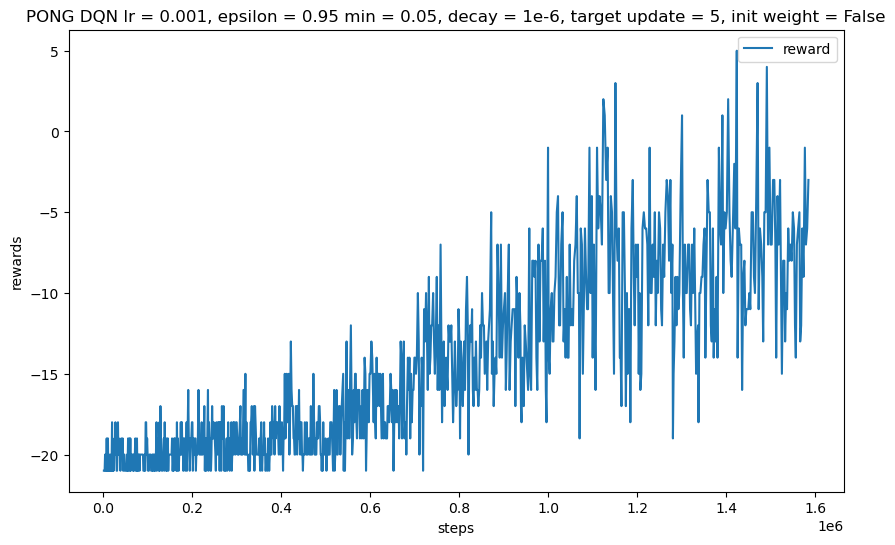

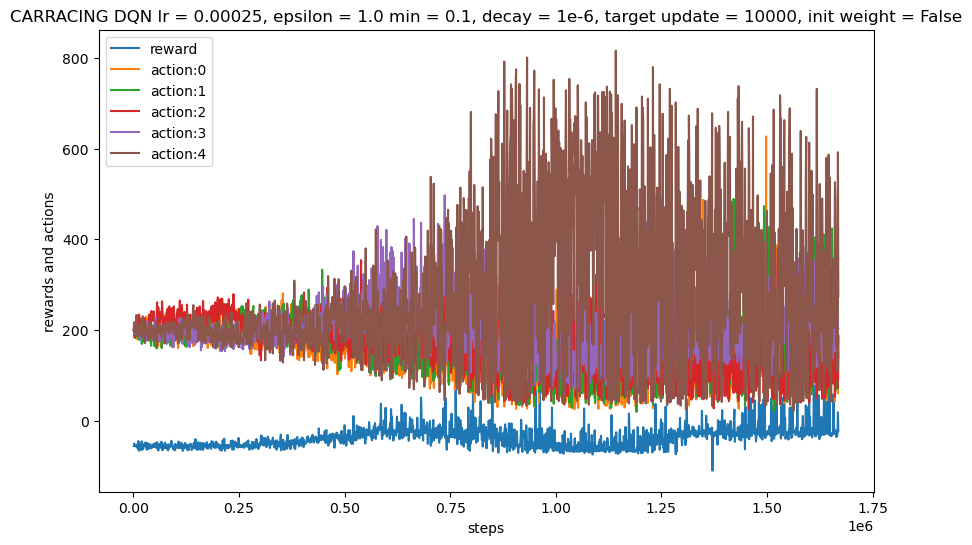

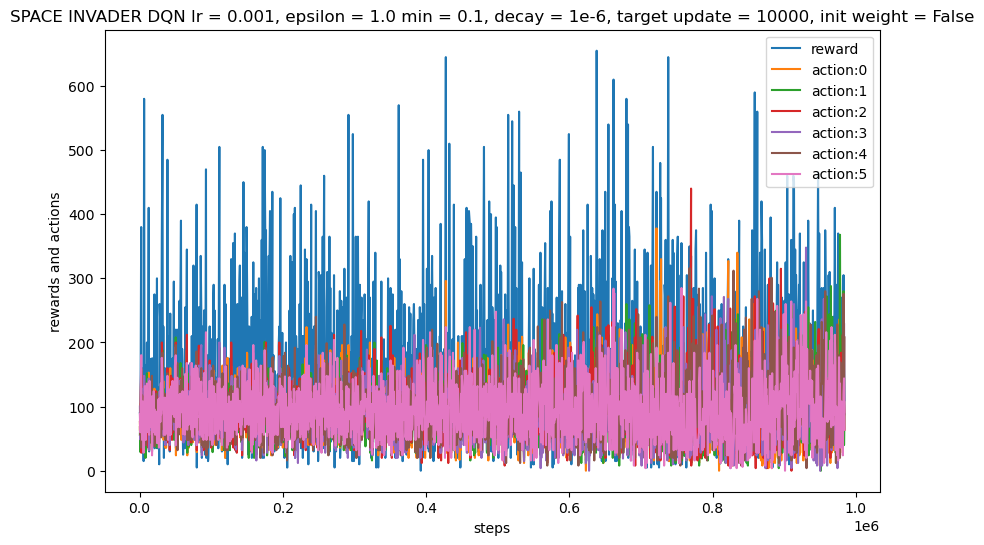

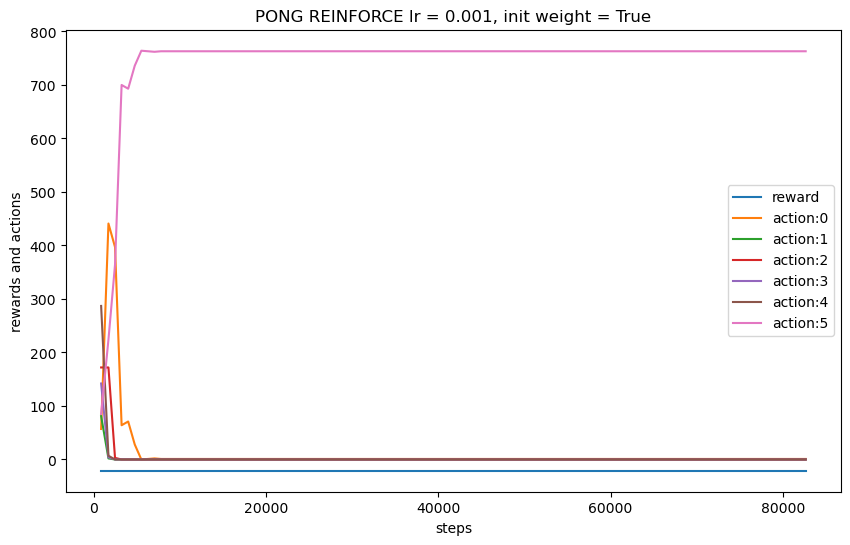

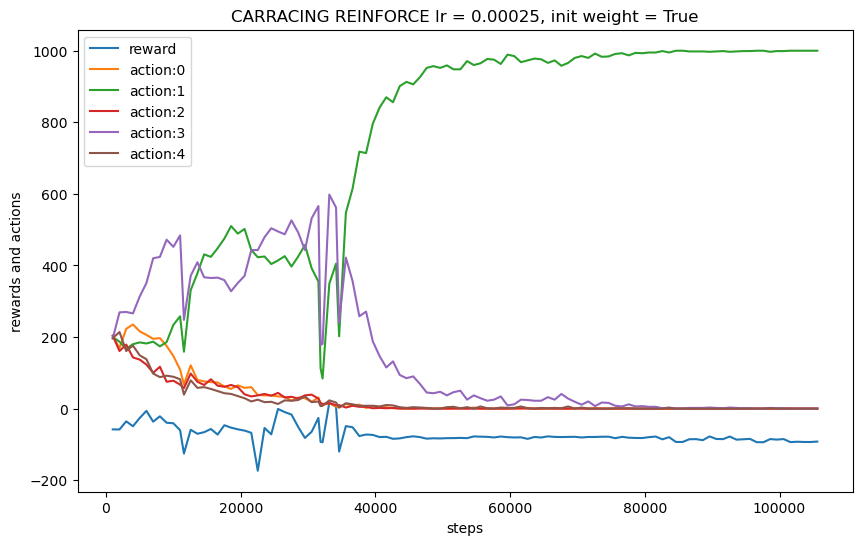

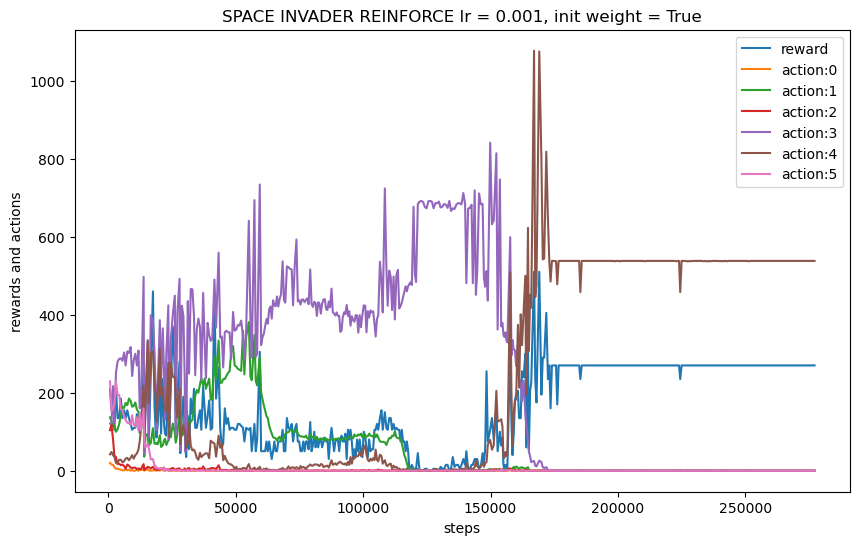

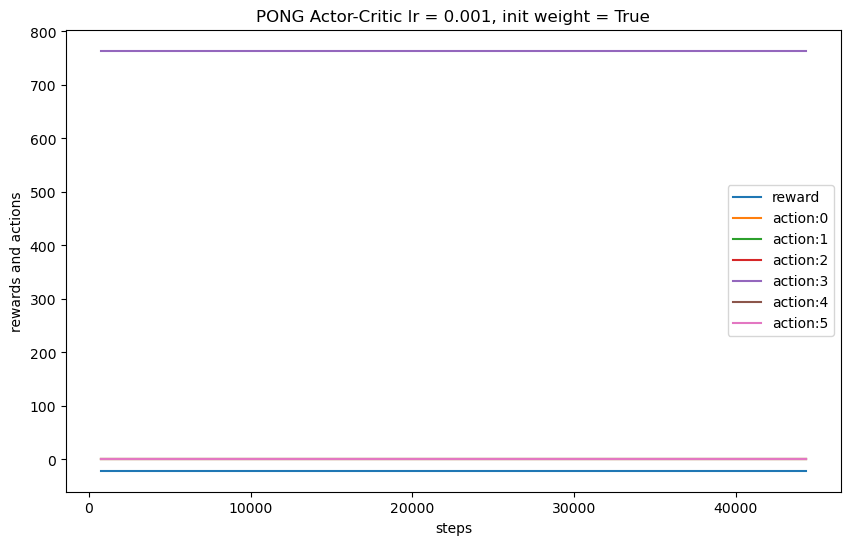

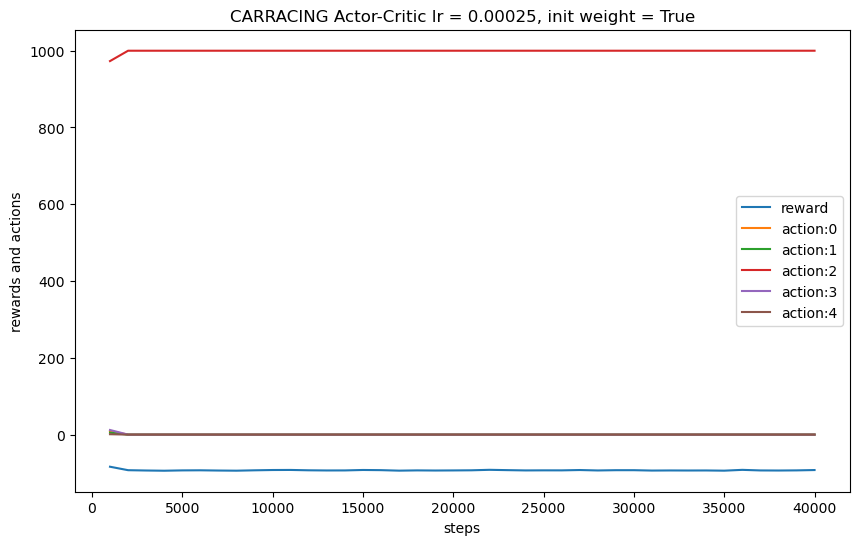

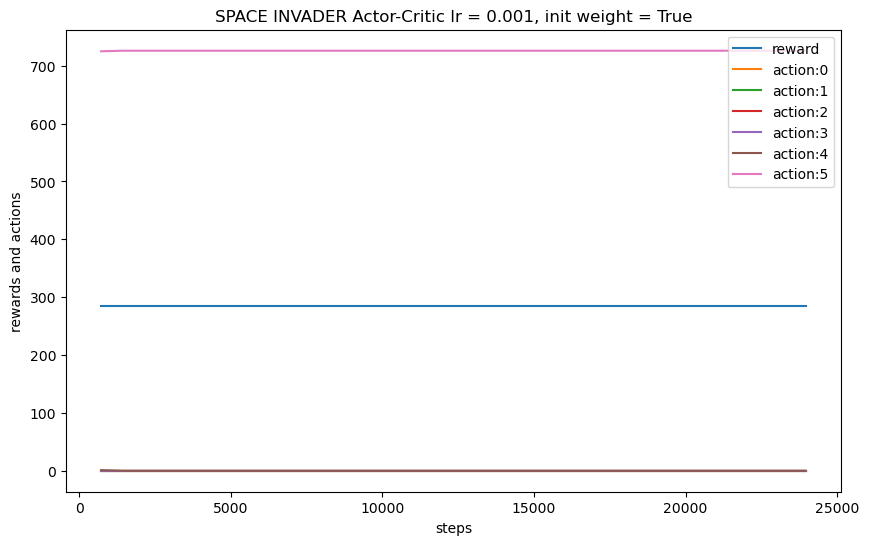

In [82]:
import matplotlib.pyplot as plt

def display_result(file, title, action_nums):
    txt = open(file, 'r')
    lines = txt.readlines()
    steps = []
    actions = dict()
    rewards = []

    if action_nums is not None:
        for i in range(action_nums):
            actions[i] = list()

    for line in lines:
        values = line.split(",")
        for value in values:
            if value.__contains__('step'):
                steps.append(int(value.split("=")[1].replace(" ", "")))
            if value.__contains__('reward'):
                rewards.append(float(value.split("=")[1].replace(" ", "")))
            if value.__contains__('action'):
                action_distribution = value.split("[")[1].split("|")
                for action in action_distribution:
                    if action.__contains__("/"):
                        params = action.split(":")
                        actions[int(params[0])].append(int(params[1].split("/")[0]))


    plt.figure(figsize=(10, 6))
    plt.plot(steps, rewards, label='reward')
    plt.xlabel('steps')

    if action_nums is not None:
        for key in actions.keys():
            plt.plot(steps, actions[key], label='action:{}'.format(key))

    if action_nums is None:
        plt.ylabel('rewards')
    else:
        plt.ylabel('rewards and actions')

    plt.title(title)
    plt.legend()
    plt.show()

display_result('/Users/kevin/PycharmProjects/reinforment-learning-work/work/record/2024-10-21 18:03:33.519521_Pong-84x84_greedy_095_dqn.txt',
               'PONG DQN lr = 0.001, epsilon = 0.95 min = 0.05, decay = 1e-6, '
               'target update = 5, init weight = False', None)

display_result(
    '/Users/kevin/PycharmProjects/reinforment-learning-work/work/record/2024-10-23 23:24:02.761045_CarRacing_greedy_10_greedy_min_01_decay_speed_1e-06_buffer_size_100000_target_update_freq_10000_use_skip_frame_False_lr_0.00025_init_w_False_dqn.txt',
               'CARRACING DQN lr = 0.00025, epsilon = 1.0 min = 0.1, decay = 1e-6, '
               'target update = 10000, init weight = False', 5)

display_result(
    '/Users/kevin/PycharmProjects/reinforment-learning-work/work/record/2024-10-24 18:13:18.416525_SpaceInvader_greedy_10_greedy_min_01_decay_speed_1e-06_buffer_size_10000_target_update_freq_20_use_skip_frame_True_lr_0.001_init_w_True_dqn.txt',
               'SPACE INVADER DQN lr = 0.001, epsilon = 1.0 min = 0.1, decay = 1e-6, '
               'target update = 10000, init weight = False', 6)

display_result('/Users/kevin/PycharmProjects/reinforment-learning-work/work/record/2024-10-23 02:53:25.472859_Pong-84x84_greedy_095_rein.txt',
               'PONG REINFORCE lr = 0.001, init weight = True', 6)

display_result(
    '/Users/kevin/PycharmProjects/reinforment-learning-work/work/record/2024-10-24 17:11:47.585750_CarRacing_greedy_10_lr_0.00025_use_skip_frame_True_init_w_False_rein.txt',
               'CARRACING REINFORCE lr = 0.00025, init weight = True', 5)

display_result(
    '/Users/kevin/PycharmProjects/reinforment-learning-work/work/record/2024-10-24 17:53:45.944967_SpaceInvader_greedy_10_lr_0.001_use_skip_frame_True_init_w_True_rein.txt',
               'SPACE INVADER REINFORCE lr = 0.001, init weight = True', 6)


display_result('/Users/kevin/PycharmProjects/reinforment-learning-work/work/record/2024-10-24 17:44:02.138112_Pong_greedy_095_lr_0.001_use_skip_frame_True_init_w_True_ac.txt',
               'PONG Actor-Critic lr = 0.001, init weight = True', 6)

display_result('/Users/kevin/PycharmProjects/reinforment-learning-work/work/record/2024-10-25 04:26:23.923507_CarRacing_greedy_10_lr_0.00025_use_skip_frame_True_init_w_False_ac.txt',
               'CARRACING Actor-Critic lr = 0.00025, init weight = True', 5)

display_result('/Users/kevin/PycharmProjects/reinforment-learning-work/work/record/2024-10-24 18:09:54.509358_SpaceInvader_greedy_10_lr_0.001_use_skip_frame_True_init_w_True_ac.txt',
               'SPACE INVADER Actor-Critic lr = 0.001, init weight = True', 6)

Export packages

In [85]:
!pip freeze > requirements.txt